In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random

from collections import namedtuple
from itertools import product

# Jester datasets http://eigentaste.berkeley.edu/dataset/
ratings_url = 'https://s3-us-west-2.amazonaws.com/ship-development/jester_ratings.dat'
df = pd.read_csv(ratings_url, sep='\s+', header=None)[0:5000]
df.columns = ['user_id', 'item_id', 'rating']

unique_users = list(df['user_id'].unique())
unique_items = list(df['item_id'].unique())

# normalize user_id (from 1 to size of unique_users)
# normalize item_id (from 1 to size of unique_items)
df.loc[:, 'user_id'] = df.user_id.apply(lambda x: unique_users.index(x) + 1)
df.loc[:, 'item_id'] = df.item_id.apply(lambda x: unique_items.index(x) + 1)

sparse_data = df.pivot_table(columns=['item_id'], index=['user_id'], values='rating').fillna(0).values

In [0]:
df.head()

,user_id,item_id,rating
0,1,1,0.219
1,1,2,-9.281
2,1,3,-9.281
3,1,4,-6.781
4,1,5,0.875


In [0]:
sparse_data

array([[ 0.219, -9.281, -9.281, ...,  0.   ,  0.   ,  0.   ],
       [-9.688,  9.938,  9.531, ...,  0.   ,  0.   ,  0.   ],
       [-9.844, -9.844, -7.219, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 7.062, -8.906, -8.906, ...,  0.   ,  0.   ,  0.   ],
       [-7.094, -2.438,  1.469, ...,  0.   ,  0.   ,  0.   ],
       [-9.281, -4.594, -8.344, ...,  0.   ,  0.   ,  0.   ]])

In [0]:
random.seed(123)

RecommenderResult = namedtuple('RecommenderResult', [
    'p', 'q', 'R', 'RSME', 'RSMES', 'time'
])

def estimate(u, m, p, q):
    return np.dot(p[u-1], q[m-1])

def rsme(p, q):
    squared_errors = []
    
    for _, row in df.iterrows(): 
        u, m, r_um = (int(row.user_id), int(row.item_id), float(row.rating))
        squared_errors.append((estimate(u, m, p, q) - r_um)**2)
        
    return np.sqrt(np.sum(squared_errors)/df.shape[0])

def rsme_cv(test_set, test_samples, R):
    squared_errors = []
    
    for u, m in test_samples: 
        r_um = float(test_set[u, m])
        squared_errors.append((R[u, m] - r_um)**2)
        
    return np.sqrt(np.mean(squared_errors))

def SGD(data, n_features=5, _lambda=0.0, n_iters=20, interim_rsme=False):
    p = np.random.normal(0, .1, (data.shape[0], n_features))
    q = np.random.normal(0, .1, (data.shape[1], n_features))
    alpha = 0.003 # learning rate
    RSMES = []

    start = datetime.datetime.now()

    for _ in range(n_iters):        
        for u, row in enumerate(data):
            for m in row.nonzero()[0]:
                r_um = float(row[m])
                err = r_um - np.dot(p[u], q[m])

                p[u] += alpha * (err * q[m] - _lambda * p[u])
                q[m] += alpha * (err * p[u] - _lambda * q[m])
                
        if interim_rsme:
            RSMES.append(rsme(p, q))
        
    time = (datetime.datetime.now() - start).seconds
    RSME = rsme(p, q)

#     print(f"SGD finished in {time} secs")
#     print('RSME:', '%.2f' % RSME)
    
    return RecommenderResult(p, q.T, np.dot(p, q.T), RSME, RSMES, time)

def ALS(data, n_features=5, _lambda=0.0, n_iters=5, interim_rsme=False):    
    m, n = data.shape
    
    p = np.random.rand(m, n_features) 
    q = np.random.rand(n_features, n)
    RSMES = []
    
    start = datetime.datetime.now()

    for _ in range(n_iters):
        p = np.linalg.solve(np.dot(q, q.T) + _lambda * np.eye(n_features), 
                            np.dot(q, data.T)).T
        q = np.linalg.solve(np.dot(p.T, p) + _lambda * np.eye(n_features),
                            np.dot(p.T, data))
        if interim_rsme:
            RSMES.append(rsme(p, q.T))
    
    time = (datetime.datetime.now() - start).seconds
    RSME = rsme(p, q.T)

#     print(f"ALS finished in {time} secs")
#     print('RSME:', '%.2f' % RSME)
    
    return RecommenderResult(p, q, np.dot(p, q), RSME, RSMES, time)

def split_train_set(data, k=10):
    test_set = data.copy()
    
    nonzero_inds = data.nonzero()
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    random.shuffle(nonzero_pairs)
    
    test_samples = [nonzero_pairs[i::k] for i in range(k)]
    result = []
    
    for test_sample in test_samples:    
        user_idxs  = [i[0] for i in test_sample]
        movie_idxs = [i[1] for i in test_sample]
        
        train_set = data.copy()
        train_set[user_idxs, movie_idxs] = 0
        
        result.append((train_set, test_set, test_sample))
    
    return result

RMSE vs iteration for SGD

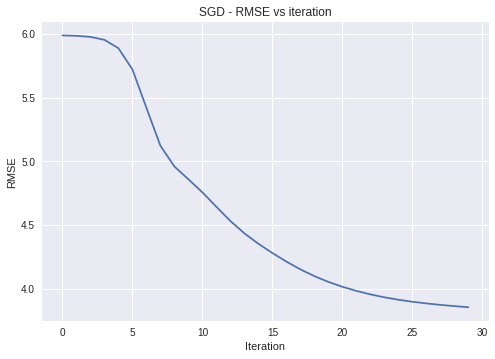

In [0]:
train_set = split_train_set(sparse_data)[0][0]
sgd_result = SGD(train_set, n_iters=30, interim_rsme=True)

plt.plot(sgd_result.RSMES)
plt.title('SGD - RMSE vs iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()

Final RMSE vs Number of features (cross-validation) for SGD

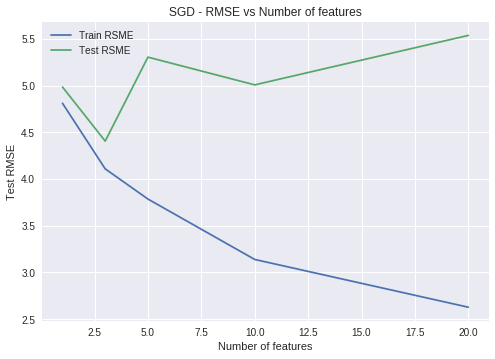

In [0]:
n_features = [1, 3, 5, 10, 20]
train_rsmes = []
test_rsmes = []
    
for n in n_features:
    n_train_rsmes = []
    n_test_rsmes = []
    
    for train_set, test_set, test_samples in split_train_set(sparse_data)[0:1]:
        sgd_result = SGD(train_set, n_features=n, n_iters=30)
        n_train_rsmes.append(sgd_result.RSME)
        n_test_rsmes.append(rsme_cv(test_set, test_samples, sgd_result.R))
    
    train_rsmes.append(np.mean(n_train_rsmes))
    test_rsmes.append(np.mean(n_test_rsmes))
    
plt.plot(n_features, train_rsmes, label='Train RSME')
plt.plot(n_features, test_rsmes, label='Test RSME')
plt.legend()
plt.title('SGD - RMSE vs Number of features')
plt.xlabel('Number of features')
plt.ylabel('Test RMSE')
plt.show()

RMSE vs lambda for SGD

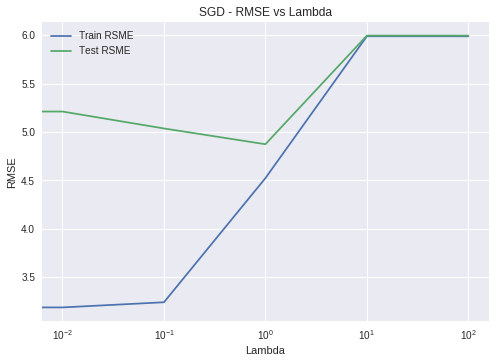

In [0]:
lambdas = [0, 0.01, 0.1, 1.0, 10.0, 100.0]
train_rsmes = []
test_rsmes = []
    
for n in lambdas:
    n_train_rsmes = []
    n_test_rsmes = []
    
    for train_set, test_set, test_samples in split_train_set(sparse_data):
        sgd_result = SGD(train_set, n_features=10, _lambda=n, n_iters=30)
        n_train_rsmes.append(sgd_result.RSME)
        n_test_rsmes.append(rsme_cv(test_set, test_samples, sgd_result.R))
    
    train_rsmes.append(np.mean(n_train_rsmes))
    test_rsmes.append(np.mean(n_test_rsmes))
    
plt.plot(lambdas, train_rsmes, label='Train RSME')
plt.plot(lambdas, test_rsmes, label='Test RSME')
plt.xscale('log')
plt.legend()
plt.title('SGD - RMSE vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.show()

RMSE vs Number of features and Lambda for SGD

In [0]:
train_set, test_set, test_samples = split_train_set(sparse_data)[0]
n_features = [1, 3, 5, 10, 20]
lambdas = [0, 0.01, 0.1, 1.0, 10.0, 100.0]
results = []

for n, l in product(n_features, lambdas):
    sgd_result = SGD(train_set, n_features=n, _lambda=l, n_iters=20)
    test_rsme = rsme_cv(test_set, test_samples, sgd_result.R)
    
    results.append({
        "Number of features": n,
        "Lambdas": l,
        "Test RMSE": round(test_rsme, 3)
    })
    
pd.pivot_table(
    pd.DataFrame(results), 
    values='Test RMSE', 
    index=['Number of features'], 
    columns=['Lambdas']
)

Lambdas,0.0,0.01,0.1,1.0,10.0,100.0
Number of features,,,,,,
1,5.000,5.008,5.013,5.975,5.988,5.988
3,4.726,4.811,4.739,5.018,5.988,5.988
5,4.696,4.956,4.733,4.981,5.988,5.988
10,4.883,4.716,4.704,4.979,5.988,5.988
20,4.791,4.700,4.766,4.904,5.988,5.988


RMSE vs iteration for ALS

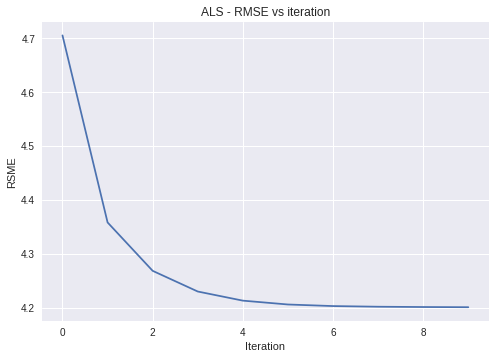

In [0]:
train_set = split_train_set(sparse_data)[0][0]
als_result = ALS(train_set, n_features=5, n_iters=10, interim_rsme=True)

plt.plot(als_result.RSMES)
plt.title('ALS - RMSE vs iteration')
plt.xlabel('Iteration')
plt.ylabel('RSME')
plt.show()

Final RMSE vs Number of features (cross-validation) for ALS

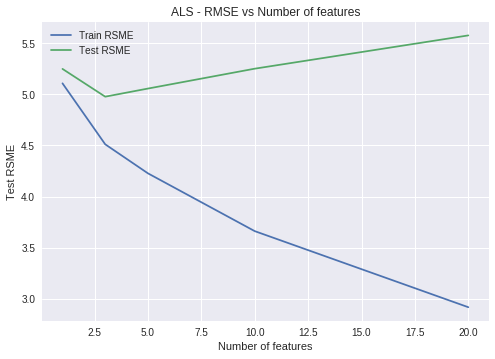

In [0]:
n_features = [1, 3, 5, 10, 20]
train_rsmes = []
test_rsmes = []
    
for n in n_features:
    n_train_rsmes = []
    n_test_rsmes = []
    
    for train_set, test_set, test_samples in split_train_set(sparse_data):
        als_result = ALS(train_set, n_features=n, n_iters=5)
        n_train_rsmes.append(als_result.RSME)
        n_test_rsmes.append(rsme_cv(test_set, test_samples, als_result.R))
    
    train_rsmes.append(np.mean(n_train_rsmes))
    test_rsmes.append(np.mean(n_test_rsmes))
    
plt.plot(n_features, train_rsmes, label='Train RSME')
plt.plot(n_features, test_rsmes, label='Test RSME')
plt.legend()
plt.title('ALS - RMSE vs Number of features')
plt.xlabel('Number of features')
plt.ylabel('Test RSME')
plt.show()

RMSE vs lambda for ALS

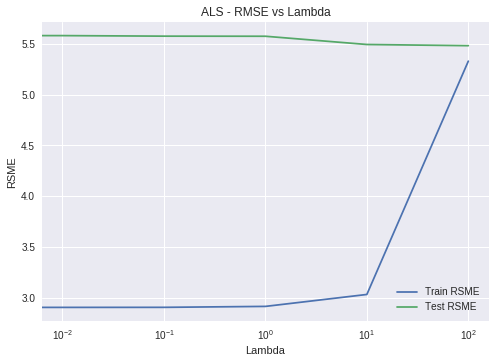

In [0]:
lambdas = [0, 0.01, 0.1, 1.0, 10.0, 100.0]
train_rsmes = []
test_rsmes = []
    
for n in lambdas:
    n_train_rsmes = []
    n_test_rsmes = []
    
    for train_set, test_set, test_samples in split_train_set(sparse_data):
        als_result = ALS(train_set, n_features=20, _lambda=n, n_iters=10)
        n_train_rsmes.append(als_result.RSME)
        n_test_rsmes.append(rsme_cv(test_set, test_samples, als_result.R))
    
    train_rsmes.append(np.mean(n_train_rsmes))
    test_rsmes.append(np.mean(n_test_rsmes))
    
plt.plot(lambdas, train_rsmes, label='Train RSME')
plt.plot(lambdas, test_rsmes, label='Test RSME')
plt.xscale('log')
plt.legend()
plt.title('ALS - RMSE vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('RSME')
plt.show()

RMSE vs Number of features and Lambda for ALS

In [0]:
train_set, test_set, test_samples = split_train_set(sparse_data)[0]
n_features = [1, 3, 5, 10, 20]
lambdas = [0, 0.01, 0.1, 1.0, 10.0, 100.0]
results = []

for n, l in product(n_features, lambdas):
    als_result = ALS(train_set, n_features=n, _lambda=l, n_iters=10)
    test_rsme = rsme_cv(test_set, test_samples, als_result.R)
    
    results.append({
        "Number of features": n,
        "Lambdas": l,
        "Test RSME": round(test_rsme, 3)
    })
    
pd.pivot_table(
    pd.DataFrame(results), 
    values='Test RSME', 
    index=['Number of features'], 
    columns=['Lambdas']
)

Lambdas,0.0,0.01,0.1,1.0,10.0,100.0
Number of features,,,,,,
1,5.517,5.517,5.517,5.518,5.529,5.752
3,5.185,5.186,5.186,5.193,5.209,5.706
5,5.261,5.270,5.359,5.363,5.283,5.705
10,5.495,5.564,5.448,5.460,5.438,5.696
20,5.792,5.772,5.775,5.763,5.694,5.696
